# Course Rating Prediction Using Neural Networks, Linear Models, Classification Models

Training models to predict course ratings whilst also extracting users' and items' latent features. 

Import Libraries

In [1]:
# ------------- General ------------- #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- Neural Networks ------------- #
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ------------- Regression Models ------------- #
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# ------------- Classification Models ------------- #
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
rs = 123

## Course Rating Prediction Using Neural Networks

### Load and processing rating dataset


In [3]:
rating_df = pd.read_csv("course_ratings.csv")
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


Recommender Class (using keras.Model class)

In [4]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # create user embedding vector
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # create bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # item embedding vector
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        # calculate embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # add components
        x = dot_user_item + user_bias + item_bias
        # output
        return tf.nn.relu(x)

In [5]:
# dummy model to see structure
dummy_model = RecommenderNet(30000, 125, 16)

_ = dummy_model(tf.constant([[0, 0], [1, 2]]))

dummy_model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding_layer            │ (2, 16)                │       480,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_bias (Embedding)           │ (2, 1)                 │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding_layer            │ (2, 16)                │         2,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_bias (Embedding)           │ (2, 1)                 │           125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,125 (1.95 MB)

 Trainable params: 512,125 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

#### Process Data

In [6]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # map user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # courses to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [7]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [8]:
encoded_data.head()

,user,item,rating
0,0,0,5
1,1,1,3
2,2,2,5
3,3,3,5
4,4,4,3


Split training and test datasets

In [9]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # training on 80%, validating 10%, testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [10]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [11]:
# dataset constants
embedding_size = 16
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())

model = RecommenderNet(num_users, num_items, embedding_size)

Compiling and Training the Model

In [12]:
# compile model
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# fit data
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=1
)

# save model
model.save('recommender_model.keras')

Epoch 1/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2314 - root_mean_squared_error: 0.4784 - val_loss: 0.1786 - val_root_mean_squared_error: 0.4219
Epoch 2/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1741 - root_mean_squared_error: 0.4164 - val_loss: 0.1788 - val_root_mean_squared_error: 0.4218
Epoch 3/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1596 - root_mean_squared_error: 0.3983 - val_loss: 0.1786 - val_root_mean_squared_error: 0.4212
Epoch 4/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1536 - root_mean_squared_error: 0.3903 - val_loss: 0.1829 - val_root_mean_squared_error: 0.4258
Epoch 5/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1513 - root_mean_squared_error: 0.3868 - val_loss: 0.1877 - val_root_mean_squared_error: 0.4311
Epoch 6/20
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1502 - root_mean_squared_error: 0.3851 - val_loss: 0.1903 - val_root_mean_squared_error: 0.4338
Epoch 7/20
2917/2917 ━━━━━━━━━━━━━━━━━━━

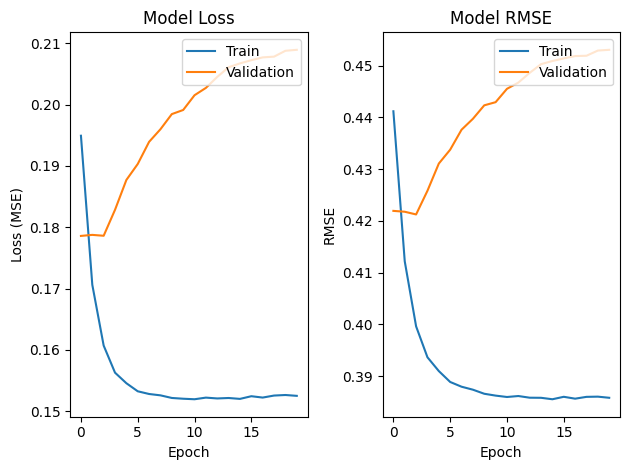

In [13]:
# plot training and validation loss + RMSE

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

Training and Test Performance

In [14]:
# training performance
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final training RMSE: {history.history['root_mean_squared_error'][-1]:.4f}")
print(f"Final validation RMSE: {history.history['val_root_mean_squared_error'][-1]:.4f}")

# performance on test set
test_loss, nn1_rmse = model.evaluate(x_test, y_test, verbose=0)
print(f"Test RMSE: {nn1_rmse:.4f}")

Final training loss: 0.1525
Final validation loss: 0.2089
Final training RMSE: 0.3858
Final validation RMSE: 0.4531
Test RMSE: 0.4493


Model Parameters

In [15]:
model.summary()

Model: "recommender_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding_layer            │ (None, 16)             │       542,416 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_bias (Embedding)           │ (None, 1)              │        33,901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding_layer            │ (None, 16)             │         2,016 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_bias (Embedding)           │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,379 (6.62 MB)

 Trainable params: 578,459 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,156,920 (4.41 MB)

Check Weights

In [16]:
# user features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [17]:
user_latent_features[0]

array([-0.2334048 , -0.01602544, -0.01455082,  0.0125162 , -0.12400324,
       -0.03399694,  0.10989492, -0.08035746, -0.05177243,  0.13859618,
       -0.06219667,  0.04327666, -0.07252017,  0.0632844 ,  0.10386229,
        0.14225483], dtype=float32)

In [18]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [19]:
item_latent_features[0]

array([-0.03499169,  0.01057279, -0.01571458,  0.01652477,  0.04299828,
        0.0001645 ,  0.01816516, -0.00561562, -0.00552264,  0.00089734,
       -0.00566252, -0.03046295, -0.00417889, -0.03154334, -0.02080055,
       -0.00403268], dtype=float32)

### Improving Model Performance

- Added Dense Hidden Layers
- Added Dropout
- Greater Embedding Size

In [20]:
class ImprovedRecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=32, hidden_layers=[64, 32], dropout_rate=0.2, l2_factor=1e-5, **kwargs):
        # init variables
        super(ImprovedRecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.hidden_layers = hidden_layers
        self.dropout_rate = dropout_rate
        
        # user embedding layer (increased size)
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(l2_factor),
            name="user_embedding"
        )
        
        # item embedding layer (increased size)
        self.item_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(l2_factor),
            name="item_embedding"
        )
        
        # bias terms
        self.user_bias = layers.Embedding(
            input_dim=num_users, 
            output_dim=1,
            embeddings_initializer="zeros",
            name="user_bias"
        )
        
        self.item_bias = layers.Embedding(
            input_dim=num_items, 
            output_dim=1,
            embeddings_initializer="zeros",
            name="item_bias"
        )
        
        # global bias terms
        self.global_bias = tf.Variable(0.0, name="global_bias")
        
        # dropout for overfitting
        self.dropout = layers.Dropout(dropout_rate)
        
        # dense layers
        self.dense_layers = []
        for units in hidden_layers:
            self.dense_layers.append(
                layers.Dense(
                    units,
                    activation="relu",
                    kernel_regularizer=keras.regularizers.l2(l2_factor)
                )
            )
        
        # output layer
        self.output_layer = layers.Dense(1, activation="linear")
        
    def call(self, inputs, training=False):
        # extract user and item indices
        user_indices = inputs[:, 0]
        item_indices = inputs[:, 1]
        
        # get embeddings and biases
        user_embedding = self.user_embedding(user_indices)
        item_embedding = self.item_embedding(item_indices)
        user_bias = self.user_bias(user_indices)
        item_bias = self.item_bias(item_indices)
        
        # apply multiple different combinations of vectors
        # dot product
        dot_product = tf.reduce_sum(user_embedding * item_embedding, axis=1, keepdims=True)
        
        # tf.concat vectors
        concat = tf.concat([user_embedding, item_embedding], axis=1)
        
        # apply dropout
        x = self.dropout(concat, training=training)
        
        # pass through dense layers
        for dense_layer in self.dense_layers:
            x = dense_layer(x)
            x = self.dropout(x, training=training)
        
        # final output prediction
        nn_output = self.output_layer(x)
        prediction = nn_output + dot_product + user_bias + item_bias + self.global_bias
        
        # ReLU
        return tf.nn.relu(prediction)

Compiling and Training Model

In [21]:
# larger embedding size, hidden layers, dropout, l2 regularisation
improved_model = ImprovedRecommenderNet(
    num_users=num_users,
    num_items=num_items,
    embedding_size=64,     
    hidden_layers=[64, 32], 
    dropout_rate=0.5,     
    l2_factor=1e-5         
)

# compile model
improved_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    restore_best_weights=True
)

# fit model, greater batch, more epochs, early stopping callback
history2 = improved_model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=30, 
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# save model
improved_model.save('improved_recommender_model.keras')

Epoch 1/30
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.1888 - root_mean_squared_error: 0.4276 - val_loss: 0.1812 - val_root_mean_squared_error: 0.4099
Epoch 2/30
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.1292 - root_mean_squared_error: 0.3303 - val_loss: 0.2149 - val_root_mean_squared_error: 0.4201
Epoch 3/30
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0617 - root_mean_squared_error: 0.1590 - val_loss: 0.2207 - val_root_mean_squared_error: 0.4251
Epoch 4/30
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0645 - root_mean_squared_error: 0.1649 - val_loss: 0.2260 - val_root_mean_squared_error: 0.4273
Epoch 5/30
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0741 - root_mean_squared_error: 0.1885 - val_loss: 0.2230 - val_root_mean_squared_error: 0.4271
Epoch 6/30
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0651 - root_mean_squared_error: 0.1669 - val_loss: 0.2256 - val_root_mean_squared_error: 0.4290


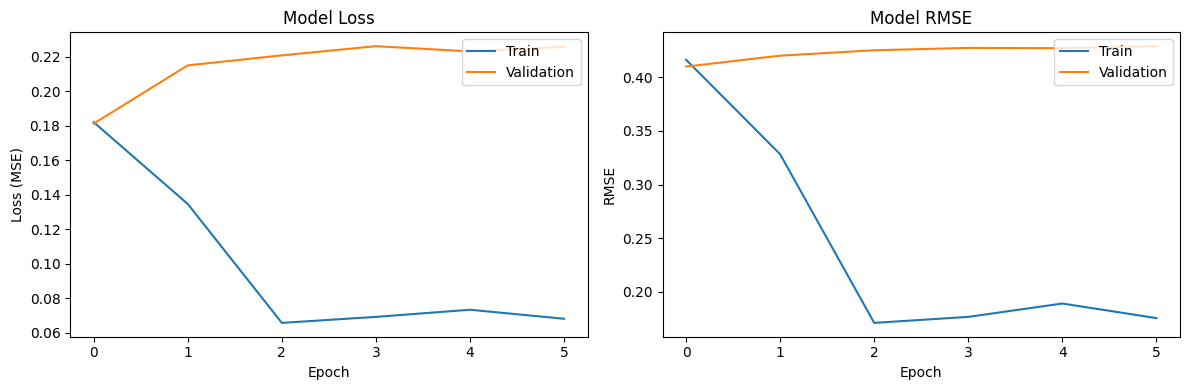

In [22]:
# plot training history (training & validation losses + rmse per epoch)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')


plt.subplot(1, 2, 2)
plt.plot(history2.history['root_mean_squared_error'])
plt.plot(history2.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

Training and Test Performance

In [23]:
# training performance
print(f"Final training loss: {history2.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history2.history['val_loss'][-1]:.4f}")
print(f"Final training RMSE: {history2.history['root_mean_squared_error'][-1]:.4f}")
print(f"Final validation RMSE: {history2.history['val_root_mean_squared_error'][-1]:.4f}")

# performance on test set
test_loss, nn2_rmse = improved_model.evaluate(x_test, y_test, verbose=0)
print(f"Test RMSE: {nn2_rmse:.4f}")

Final training loss: 0.0681
Final validation loss: 0.2256
Final training RMSE: 0.1755
Final validation RMSE: 0.4290
Test RMSE: 0.4089


A better TEST RMSE than the previous one. Also trained very quickly due to the early stopping.

## Regression-Based Rating Score Prediction

Load Embeddings

In [24]:
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

user_emb = pd.read_csv(user_emb_url)
item_emb = pd.read_csv(item_emb_url)

In [25]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


In [26]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [27]:
# merge user embedding features
user_emb_merged = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# merge course embedding features
merged_df = pd.merge(user_emb_merged, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [28]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,5,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,5,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,5,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


Combining User and Course Features

In [29]:
# 16 size columns
u_features = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]  

# user embeddings
user_embeddings = merged_df[u_features]
# course embeddings
course_embeddings = merged_df[c_features]
# ratings
ratings = merged_df['rating']

# aggregate columns 
regression_dataset = user_embeddings + course_embeddings.values
# rename column
regression_dataset.columns = [f"Feature{i}" for i in range(16)]
# add rating column
regression_dataset['rating'] = ratings

regression_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,5
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,5
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,5
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3


Data is ready for training

In [30]:
X = regression_dataset.iloc[:, :-1]
y = regression_dataset.iloc[:, -1]
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


Split Sets, Then Scale

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

##### List of Models
- Linear Regression
- Ridge Regression
- Lasso Regression
- ElasticNet Regression
- Random Forest Regression
- Gradient Boosting Regression
- Support Vector Regression (SVR)

Param Grids For All Models

In [32]:
param_grid = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
            'max_iter': [1000, 3000]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.5, 0.7, 0.9],
            'max_iter': [1000, 3000]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=123),
        'params': {
            'n_estimators': [100],
            'max_depth': [10],
            'min_samples_split': [5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=123),
        'params': {
            'n_estimators': [100],
            'learning_rate': [0.01],
            'max_depth': [3]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear'],
            'C': [0.1],
            'gamma': ['scale']
        }
    }
}

Train Models and Store Test Set Results

In [33]:
# results and params (35 mins ish run)
results_regression = {}
best_models_regression = {}

for name, model_info in param_grid.items():
    print(f"Fitting {name}")
        
    # grid search
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,  
        verbose=2
    )
    
    # no hyperparameters (linear)
    if not model_info['params']:
        model = model_info['model']
        model.fit(X_train_ss, y_train)
        best_models_regression[name] = model
    else:
        # use parameters
        grid_search.fit(X_train_ss, y_train)
        print(f"Best parameters: {grid_search.best_params_}")
        best_models_regression[name] = grid_search.best_estimator_
            
    # test set
    model = best_models_regression[name]
    y_pred = model.predict(X_test_ss)
    
    # rmse
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results_regression[name] = {
        'RMSE': rmse,
    }

Fitting Linear Regression
Fitting Ridge
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'alpha': 100.0, 'solver': 'auto'}
Fitting Lasso
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'alpha': 0.01, 'max_iter': 1000}
Fitting ElasticNet
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 1000}
Fitting Random Forest
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Fitting Gradient Boosting
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Fitting SVR
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Comparing Regression Models

In [34]:
print("\nRMSE Values for All Models:")
print("-" * 50)
print(f"{'Model':<30} {'RMSE':<10}")
print("-" * 50)

# sort by RMSE
sorted_results = sorted(results_regression.items(), key=lambda x: x[1]['RMSE'])

for model_name, metrics in sorted_results:
    rmse = metrics['RMSE']
    print(f"{model_name:<30} {rmse:.4f}")

# print models
best_model_name = sorted_results[0][0]
best_rmse = sorted_results[0][1]['RMSE']
print("-" * 50)
print(f"Best Model: {best_model_name} with RMSE: {best_rmse:.4f}")


RMSE Values for All Models:
--------------------------------------------------
Model                          RMSE      
--------------------------------------------------
Gradient Boosting              0.8138
Lasso                          0.8138
ElasticNet                     0.8138
Ridge                          0.8138
Linear Regression              0.8138
Random Forest                  0.8140
SVR                            0.8148
--------------------------------------------------
Best Model: Gradient Boosting with RMSE: 0.8138


Graident Boosting, Lasso, ElasticNet, Ridge and Linear Regression achieve equal RMSE scores and are the best. Random Forest and SVR achieve very close RMSE values but are very marginally worse, possibly due to overfitting due to them being more complex models. With that being said, none come close to the RMSE value of the neural network, which is expected.

## Classification-Based Rating Score Prediction

In [35]:
X_c = regression_dataset.iloc[:, :-1]
y_raw_c = regression_dataset.iloc[:, -1]

# create label encoder
label_encoder = LabelEncoder()

# encoded y
y_c = label_encoder.fit_transform(y_raw_c.values.ravel())

Split and Scale

In [36]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_c, y_c, test_size=0.3, random_state=rs)

X_train_class_ss = scaler.fit_transform(X_train_class)
X_test_class_ss = scaler.transform(X_test_class)

Classification Parameter Grid

In [37]:
classification_param_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=123, max_iter=10000),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'solver': ['liblinear', 'saga']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=123),
        'params': {
            'max_depth': [20],
            'min_samples_split': [2, 5]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=123),
        'params': {
            'n_estimators': [100],
            'max_depth': [10],
            'min_samples_split': [5]
        }
    },
    'Bagging': {
        'model': BaggingClassifier(random_state=123),
        'params': {
            'n_estimators': [20],
            'max_samples': [0.7, 1.0]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=123),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=123),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01],
            'max_depth': [3]
        }
    }
}

In [39]:
classification_results = {}
classification_models = {}

for name, model_info in classification_param_grid.items():
    print(f"Fitting {name} classifier")
    
    # grid search
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=3,
        scoring='balanced_accuracy',  
        n_jobs=-1,
        verbose=2
    )
    
    # fit model
    if not model_info['params']:
        model = model_info['model']
        model.fit(X_train_class_ss, y_train_class)
        classification_models[name] = model
    else:
        grid_search.fit(X_train_class_ss, y_train_class)
        print(f"Best parameters: {grid_search.best_params_}")
        classification_models[name] = grid_search.best_estimator_
    
    # evaluate test
    model = classification_models[name]
    y_pred = model.predict(X_test_class_ss)
    
    # change to numerical
    if len(np.unique(y_pred)) <= 2:
        numeric_predictions = np.where(y_pred == 1, 4.0, 2.0)
    
    # multi-class
    else:
        # classes already numeric
        numeric_predictions = y_pred

    # store
    accuracy = accuracy_score(y_test_class, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_class, numeric_predictions))
    classification_results[name] = {
        'Accuracy': accuracy,
        'RMSE': rmse
    }


Fitting Logistic Regression classifier
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'C': 1.0, 'solver': 'saga'}
Fitting Decision Tree classifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'max_depth': 20, 'min_samples_split': 5}
Fitting Random Forest classifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Fitting Bagging classifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'max_samples': 1.0, 'n_estimators': 20}
Fitting AdaBoost classifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'learning_rate': 0.01, 'n_estimators': 100}
Fitting Gradient Boosting classifier
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [40]:
for name, model_info in classification_param_grid.items():
    model = classification_models[name]
    y_pred = model.predict(X_test_class_ss)

    # classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test_class, y_pred))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.33      0.46      0.39     23155
           1       0.34      0.27      0.30     23637
           2       0.33      0.28      0.30     23200

    accuracy                           0.33     69992
   macro avg       0.33      0.33      0.33     69992
weighted avg       0.33      0.33      0.33     69992


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.33      0.13      0.18     23155
           1       0.34      0.73      0.46     23637
           2       0.33      0.14      0.20     23200

    accuracy                           0.34     69992
   macro avg       0.33      0.33      0.28     69992
weighted avg       0.33      0.34      0.28     69992


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.34      0.44      0.38     231

c:\Users\Gustavo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gustavo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gustavo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

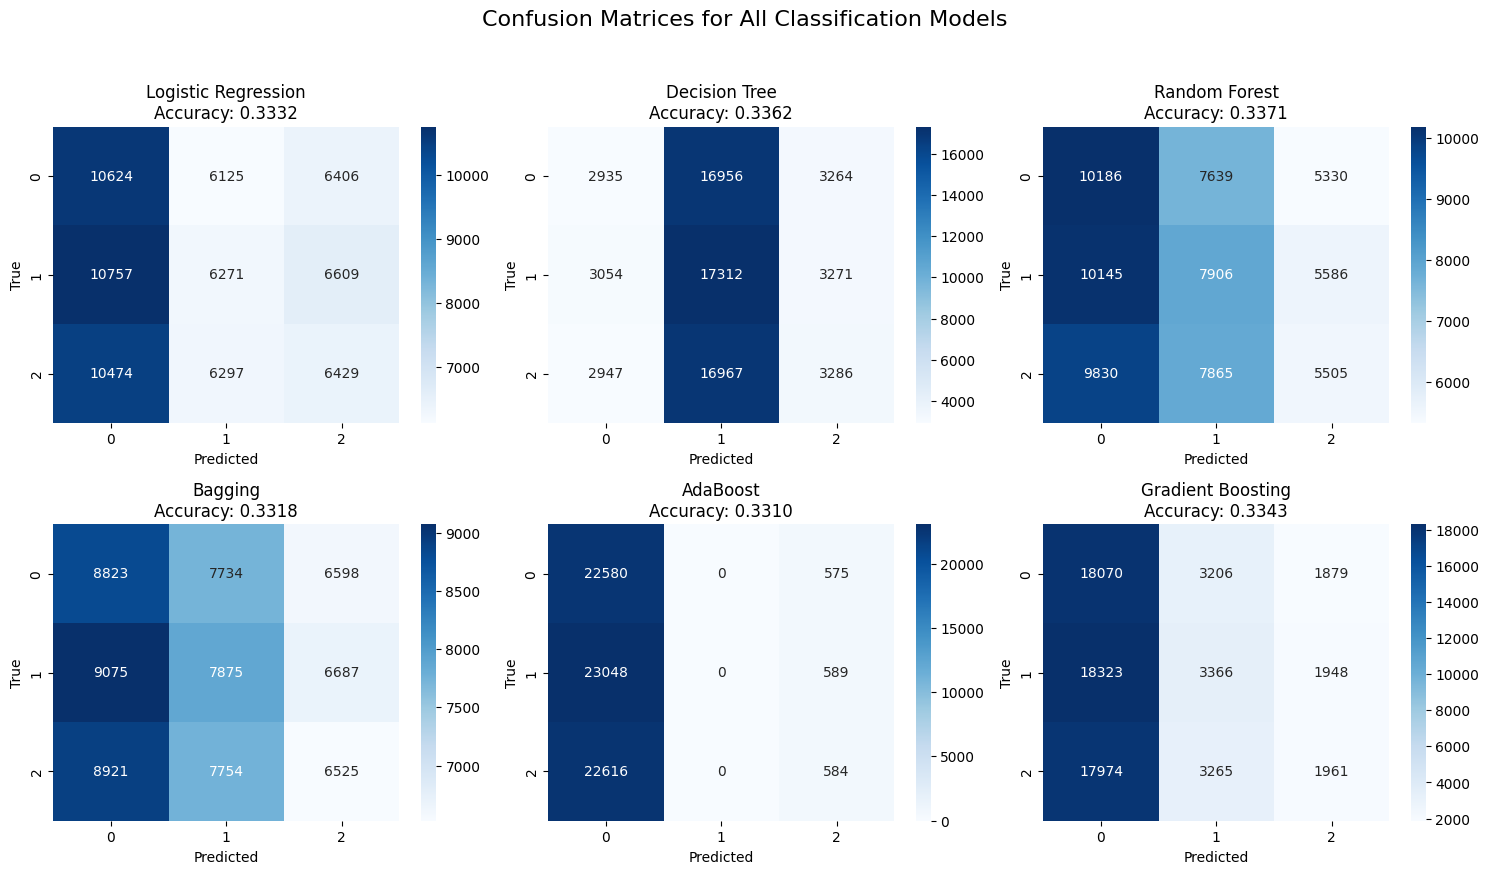

In [41]:
# unique class labels
class_labels = np.unique(y_test_class)
n_classes = len(class_labels)

# grid layout 3x3
n_models = len(classification_models)
n_cols = 3
n_rows = 3

# create figure
plt.figure(figsize=(15, n_rows * 4))

# plot cm for each model
for i, (name, model) in enumerate(classification_models.items()):
    # get predictions
    y_pred = model.predict(X_test_class_ss)
    
    # calculate confusion matrix
    cm = confusion_matrix(y_test_class, y_pred)
    
    # create subplot
    plt.subplot(n_rows, n_cols, i + 1)
    
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels)
    
    # add labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name}\nAccuracy: {accuracy_score(y_test_class, y_pred):.4f}')
    
    # adjust layout
    plt.tight_layout()

plt.suptitle('Confusion Matrices for All Classification Models', 
             fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

Terrible results from the classification model. The regression models are much better for this task.

##### Comparing All Models

In [42]:
# collaboraitve filtering models using surprise
cb_filtering_results = {
    "KNN User-Based": 1.289513370864603,
    "KNN Item-Based": 1.289513128591097,
    "NMF": 1.2901388595105105
}

RMSE Comparison Across All Models (Lower is Better):
                                   Model     RMSE
                    Neural Network - NN2 0.408922
                    Neural Network - NN1 0.449327
          Regression - Gradient Boosting 0.813813
                      Regression - Lasso 0.813818
                 Regression - ElasticNet 0.813818
                      Regression - Ridge 0.813835
          Regression - Linear Regression 0.813835
              Regression - Random Forest 0.813990
                        Regression - SVR 0.814788
          Classification - Decision Tree 0.964361
          Classification - Random Forest 1.145709
                Classification - Bagging 1.154721
    Classification - Logistic Regression 1.179098
      Classification - Gradient Boosting 1.231527
               Classification - AdaBoost 1.288799
Collaborative Filtering - KNN Item-Based 1.289513
Collaborative Filtering - KNN User-Based 1.289513
           Collaborative Filtering - NMF 1.2901

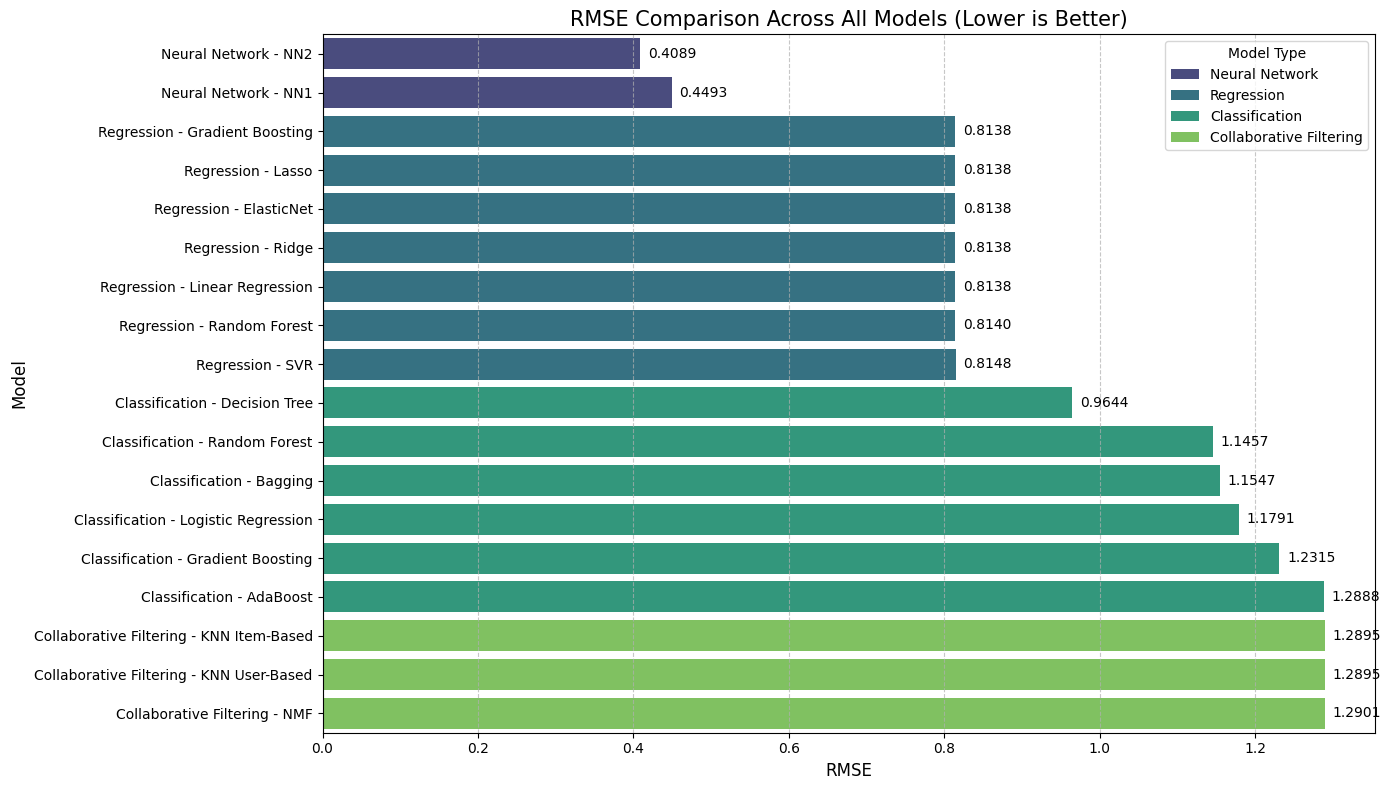

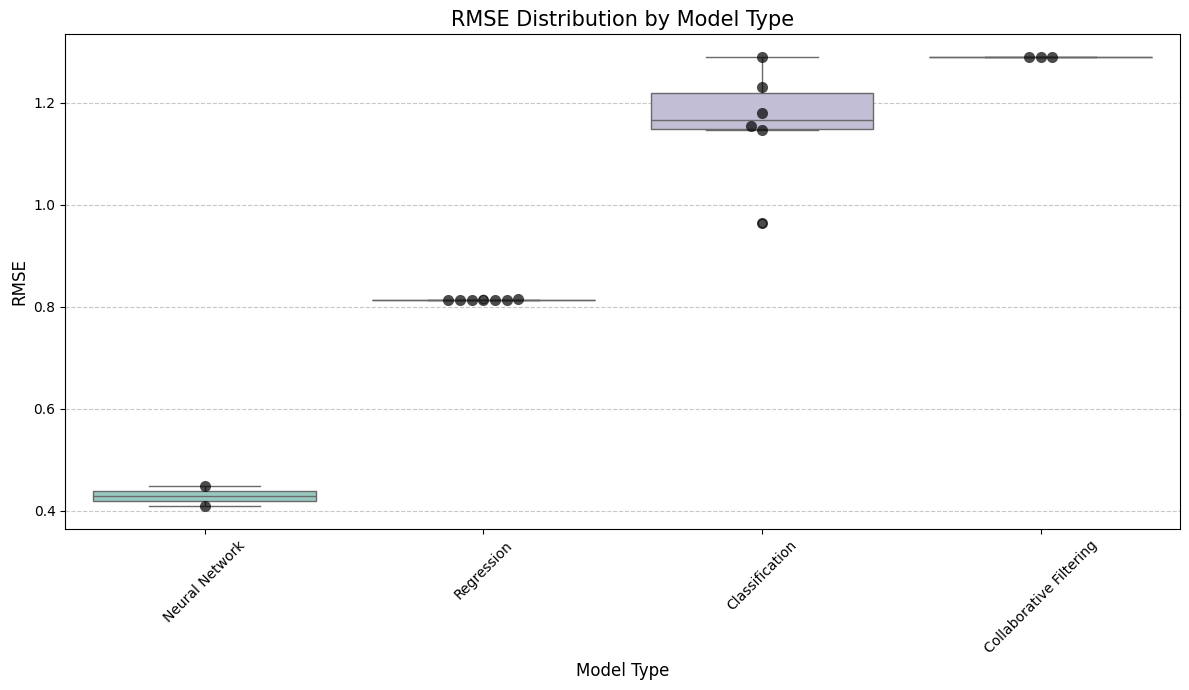

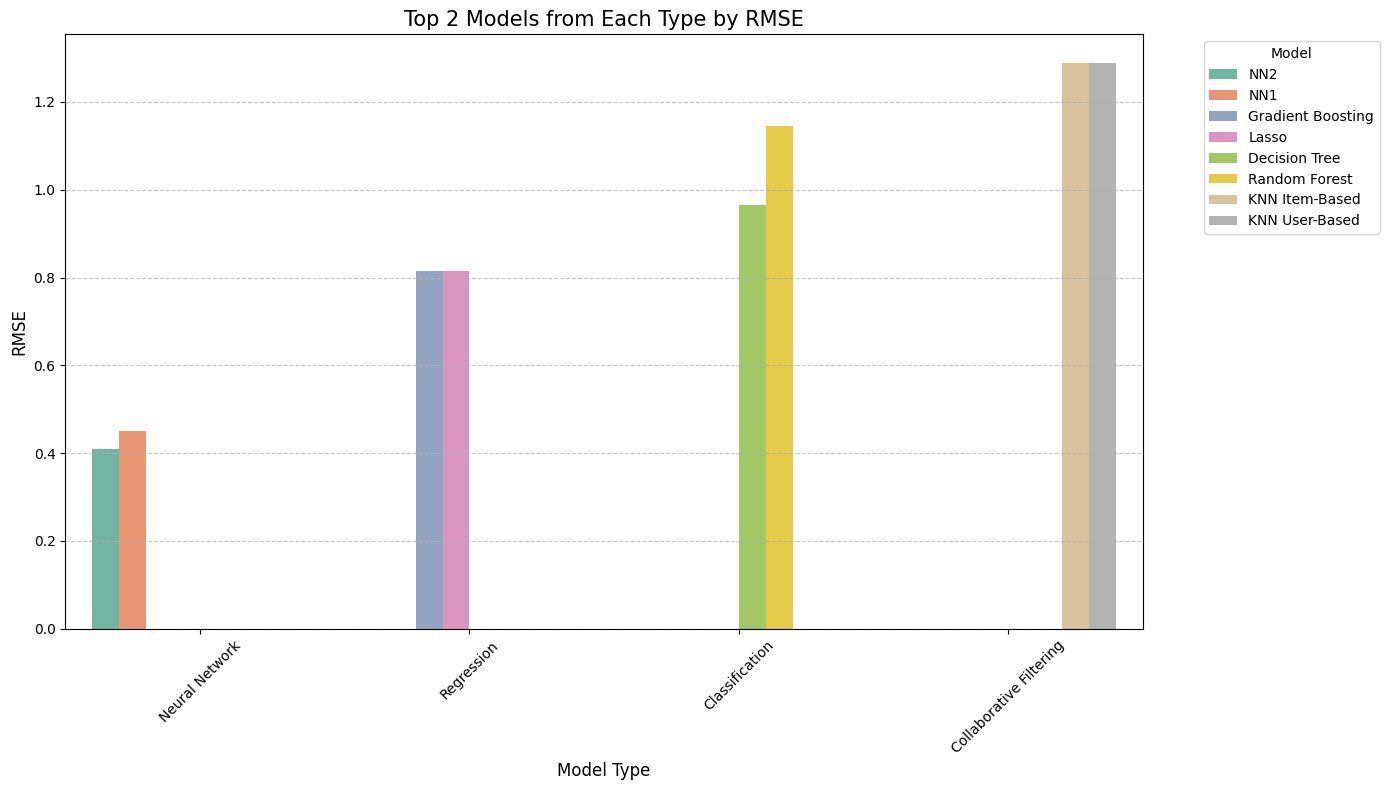


Best Overall Model: Neural Network - NN2 with RMSE: 0.4089

Best Model by Type:
Classification: Decision Tree (RMSE: 0.9644)
Collaborative Filtering: KNN Item-Based (RMSE: 1.2895)
Neural Network: NN2 (RMSE: 0.4089)
Regression: Gradient Boosting (RMSE: 0.8138)

Model Improvements Relative to Worst Model:
                         Model     RMSE  Improvement (%)
          Neural Network - NN2 0.408922            68.30
          Neural Network - NN1 0.449327            65.17
Regression - Gradient Boosting 0.813813            36.92
            Regression - Lasso 0.813818            36.92
       Regression - ElasticNet 0.813818            36.92
            Regression - Ridge 0.813835            36.92
Regression - Linear Regression 0.813835            36.92
    Regression - Random Forest 0.813990            36.91
              Regression - SVR 0.814788            36.84
Classification - Decision Tree 0.964361            25.25

Model Improvements Relative to Collaborative Filtering Average:
  

In [44]:
def compare_all_models_rmse(classification_results, regression_results, nn_results, cb_filtering_results):
    # all rmse scores
    all_rmse = {}
    
    # add classification models
    for model_name, metrics in classification_results.items():
        if 'RMSE' in metrics:
            all_rmse[f"Classification - {model_name}"] = metrics['RMSE']
    
    # add regression models
    for model_name, metrics in regression_results.items():
        if isinstance(metrics, dict) and 'RMSE' in metrics:
            all_rmse[f"Regression - {model_name}"] = metrics['RMSE']
        elif isinstance(metrics, (int, float)):  
            all_rmse[f"Regression - {model_name}"] = metrics
    
    # add neural networks
    if isinstance(nn_results, dict):
        for model_name, rmse in nn_results.items():
            all_rmse[f"Neural Network - {model_name}"] = rmse
    else:
        # if nn_rmse values are provided directly
        all_rmse["Neural Network - NN1"] = nn1_rmse
        all_rmse["Neural Network - NN2"] = nn2_rmse
        
    # add collaborative filtering results
    for model_name, rmse in cb_filtering_results.items():
        all_rmse[f"Collaborative Filtering - {model_name}"] = rmse
    
    # create df 
    rmse_df = pd.DataFrame({
        'Model': list(all_rmse.keys()),
        'RMSE': list(all_rmse.values())
    })
    
    # grouping
    rmse_df['Model Type'] = rmse_df['Model'].apply(lambda x: x.split(' - ')[0])
    rmse_df['Model Name'] = rmse_df['Model'].apply(lambda x: x.split(' - ')[1] if ' - ' in x else x)
    
    # sort rmse
    rmse_df = rmse_df.sort_values('RMSE')
    
    return rmse_df

# dict
nn_results = {
    "NN1": nn1_rmse,
    "NN2": nn2_rmse
}

# compare
rmse_comparison = compare_all_models_rmse(classification_results, results_regression, nn_results, cb_filtering_results)

# results
print("RMSE Comparison Across All Models (Lower is Better):")
print(rmse_comparison[['Model', 'RMSE']].to_string(index=False))

# average rmse by type
avg_by_type = rmse_comparison.groupby('Model Type')['RMSE'].agg(['mean', 'min', 'max', 'count']).reset_index()
avg_by_type = avg_by_type.sort_values('mean')

print("\nAverage RMSE by Model Type:")
print(avg_by_type.to_string(index=False))

# visualizations
# bar chart with color by model type
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='RMSE', y='Model', data=rmse_comparison, hue='Model Type', dodge=False, palette='viridis')
plt.title('RMSE Comparison Across All Models (Lower is Better)', fontsize=15)
plt.xlabel('RMSE', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# add value labels to bars
for i, v in enumerate(rmse_comparison['RMSE']):
    ax.text(v + 0.01, i, f"{v:.4f}", va='center')

plt.tight_layout()
plt.show()

# box plot by model type with individual points
plt.figure(figsize=(12, 7))
sns.boxplot(x='Model Type', y='RMSE', hue='Model Type', data=rmse_comparison, palette='Set3', legend=False)
sns.swarmplot(x='Model Type', y='RMSE', data=rmse_comparison, color='black', size=8, alpha=0.7)
plt.title('RMSE Distribution by Model Type', fontsize=15)
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# grouped bar chart for top models of each type
# top 2 models from each type
top_models = rmse_comparison.groupby('Model Type').head(2).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(x='Model Type', y='RMSE', hue='Model Name', data=top_models, palette='Set2')
plt.title('Top 2 Models from Each Type by RMSE', fontsize=15)
plt.xlabel('Model Type', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# best model
best_model = rmse_comparison.iloc[0]
print(f"\nBest Overall Model: {best_model['Model']} with RMSE: {best_model['RMSE']:.4f}")

# best model by type
best_by_type = rmse_comparison.loc[rmse_comparison.groupby('Model Type')['RMSE'].idxmin()]
print("\nBest Model by Type:")
for _, row in best_by_type.iterrows():
    print(f"{row['Model Type']}: {row['Model Name']} (RMSE: {row['RMSE']:.4f})")

# improvement percentages
baseline_rmse = rmse_comparison['RMSE'].max()
rmse_comparison['Improvement (%)'] = ((baseline_rmse - rmse_comparison['RMSE']) / baseline_rmse * 100).round(2)

print("\nModel Improvements Relative to Worst Model:")
print(rmse_comparison[['Model', 'RMSE', 'Improvement (%)']].head(10).to_string(index=False))

# calculate relative improvement over baseline methods
# assuming collaborative filtering is the baseline approach
cf_avg = rmse_comparison[rmse_comparison['Model Type'] == 'Collaborative Filtering']['RMSE'].mean()
rmse_comparison['Improvement vs CF (%)'] = ((cf_avg - rmse_comparison['RMSE']) / cf_avg * 100).round(2)

print("\nModel Improvements Relative to Collaborative Filtering Average:")
print(rmse_comparison[['Model', 'RMSE', 'Improvement vs CF (%)']].sort_values('Improvement vs CF (%)', ascending=False).head(10).to_string(index=False))

Out of all models, the neural networks are the best, followed by the regression models.